# Build a predictive maintenance model for a delivery company - Classification

## **Overview**
- This project aims to build a predictive maintenance model for a delivery company to predict potential failures in its delivery fleet. The model employs classification techniques to identify vehicles at risk of breakdown, allowing for proactive maintenance and minimizing unexpected downtime.

## **Objective**
- The primary objective is to increase the reliability and availability of the delivery fleet by predicting potential failures before they occur. This will help in scheduling maintenance, reducing costs associated with unscheduled repairs, and improving overall customer satisfaction by ensuring timely deliveries.

## Goal
- You are tasked with building a predictive model using machine learning to predict the probability of a device failure. When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure.

## Import libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from termcolor import colored

import warnings 
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)
pd.set_option("display.width",600)
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

from pycaret.classification import*

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

## Load and EDA

In [4]:
df = pd.read_csv("failure.csv")
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [10]:
df.sample(5)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
120426,2015-09-23,W1F1DABR,0,155564696,0,0,0,11,35,0,0,0
42350,2015-02-25,W1F1CLH3,0,243306600,0,0,0,9,220555,0,0,0
108400,2015-07-31,S1F0GRB1,0,60503480,0,0,0,67,251201,0,0,0
78500,2015-05-06,Z1F0L3BL,0,19939520,0,0,0,6,309774,0,0,0
118143,2015-09-08,W1F0FML1,0,143579064,0,0,0,11,241515,0,0,23


In [8]:
def check_df(df, head=5, tail=5):
    print(" SHAPE ".center(70, '*'))
    print('Observations -------> {}'.format(df.shape[0]))
    print('Features     -------> {}'.format(df.shape[1]))
    print(f"Shape of dataset: {colored(df.shape, 'red')}")
    print(" TYPES OF FEATURES ".center(70, '*'))
    print(df.dtypes,"\n")
    print(" INFO ".center(70, "*"))
    print("\n",df.info(),"\n")
    print(' DUPLICATE VALUE ANALYSIS '.center(70, '*'))
    print("\n",df.duplicated().sum(),"\n")
    print(" QUANTILES ".center(70, '*'))
    numerical_df = df.select_dtypes(include=["number"])
    print(numerical_df.quantile([0, 0.05, 0.50, 0.95, 0.90, 1]).T, "\n")
    print(" MISSING VALUES ".center(70, "*"))
    print(df.isnull().sum())

check_df(df)

******************************* SHAPE ********************************
Observations -------> 124494
Features     -------> 12
Shape of dataset: (124494, 12)
************************* TYPES OF FEATURES **************************
date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
dtype: object 

******************************** INFO ********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  in

In [18]:
## Thus we found number of unique values of all columns with this function 
def check_unique(df):

  dict = {}
  for i in list(df.columns):
    dict[i] = df[i].nunique()
  nunq = pd.DataFrame(dict,index=["Number of Unique"]).transpose().sort_values(by="Number of Unique",ascending=False)
  return nunq
check_unique(df)  



,Number of Unique
attribute1,123878
attribute6,44838
device,1168
attribute2,558
date,304
attribute4,115
attribute9,65
attribute5,60
attribute3,47
attribute7,28


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
failure,124494.000,0.001,0.029,0.000,0.000,0.000,0.000,1.000
attribute1,124494.000,122386752.674,70459597.488,0.000,61276754.000,122795744.000,183308370.000,244140480.000
attribute2,124494.000,159.485,2179.658,0.000,0.000,0.000,0.000,64968.000
attribute3,124494.000,9.940,185.747,0.000,0.000,0.000,0.000,24929.000
attribute4,124494.000,1.741,22.909,0.000,0.000,0.000,0.000,1666.000
attribute5,124494.000,14.223,15.943,1.000,8.000,10.000,12.000,98.000
attribute6,124494.000,260172.858,99151.010,8.000,221452.000,249799.500,310266.000,689161.000
attribute7,124494.000,0.293,7.437,0.000,0.000,0.000,0.000,832.000
attribute8,124494.000,0.293,7.437,0.000,0.000,0.000,0.000,832.000
attribute9,124494.000,12.452,191.426,0.000,0.000,0.000,0.000,18701.000


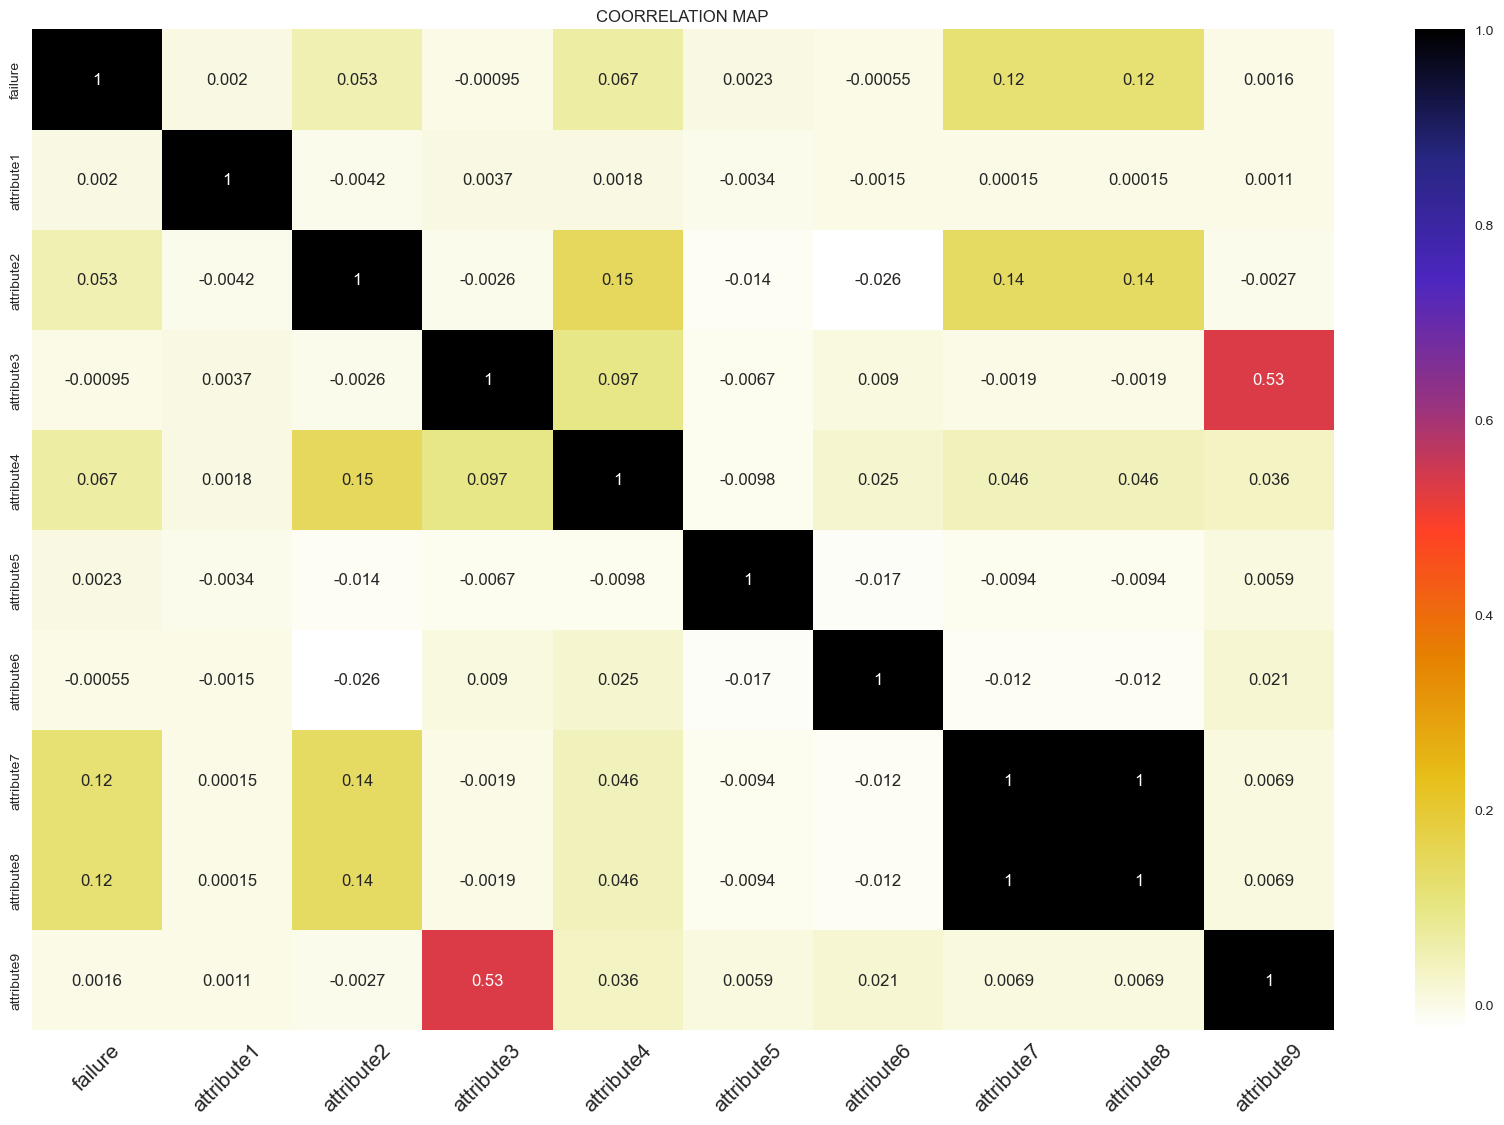

In [19]:
plt.figure(figsize=(21,13))
plt.xticks(rotation=45, size=15)
plt.title("COORRELATION MAP")
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap=plt.cm.CMRmap_r);

In [16]:
abs(df.corr(numeric_only=True)["failure"]).sort_values(ascending=False)

failure      1.000
attribute7   0.119
attribute8   0.119
attribute4   0.067
attribute2   0.053
attribute5   0.002
attribute1   0.002
attribute9   0.002
attribute3   0.001
attribute6   0.001
Name: failure, dtype: float64

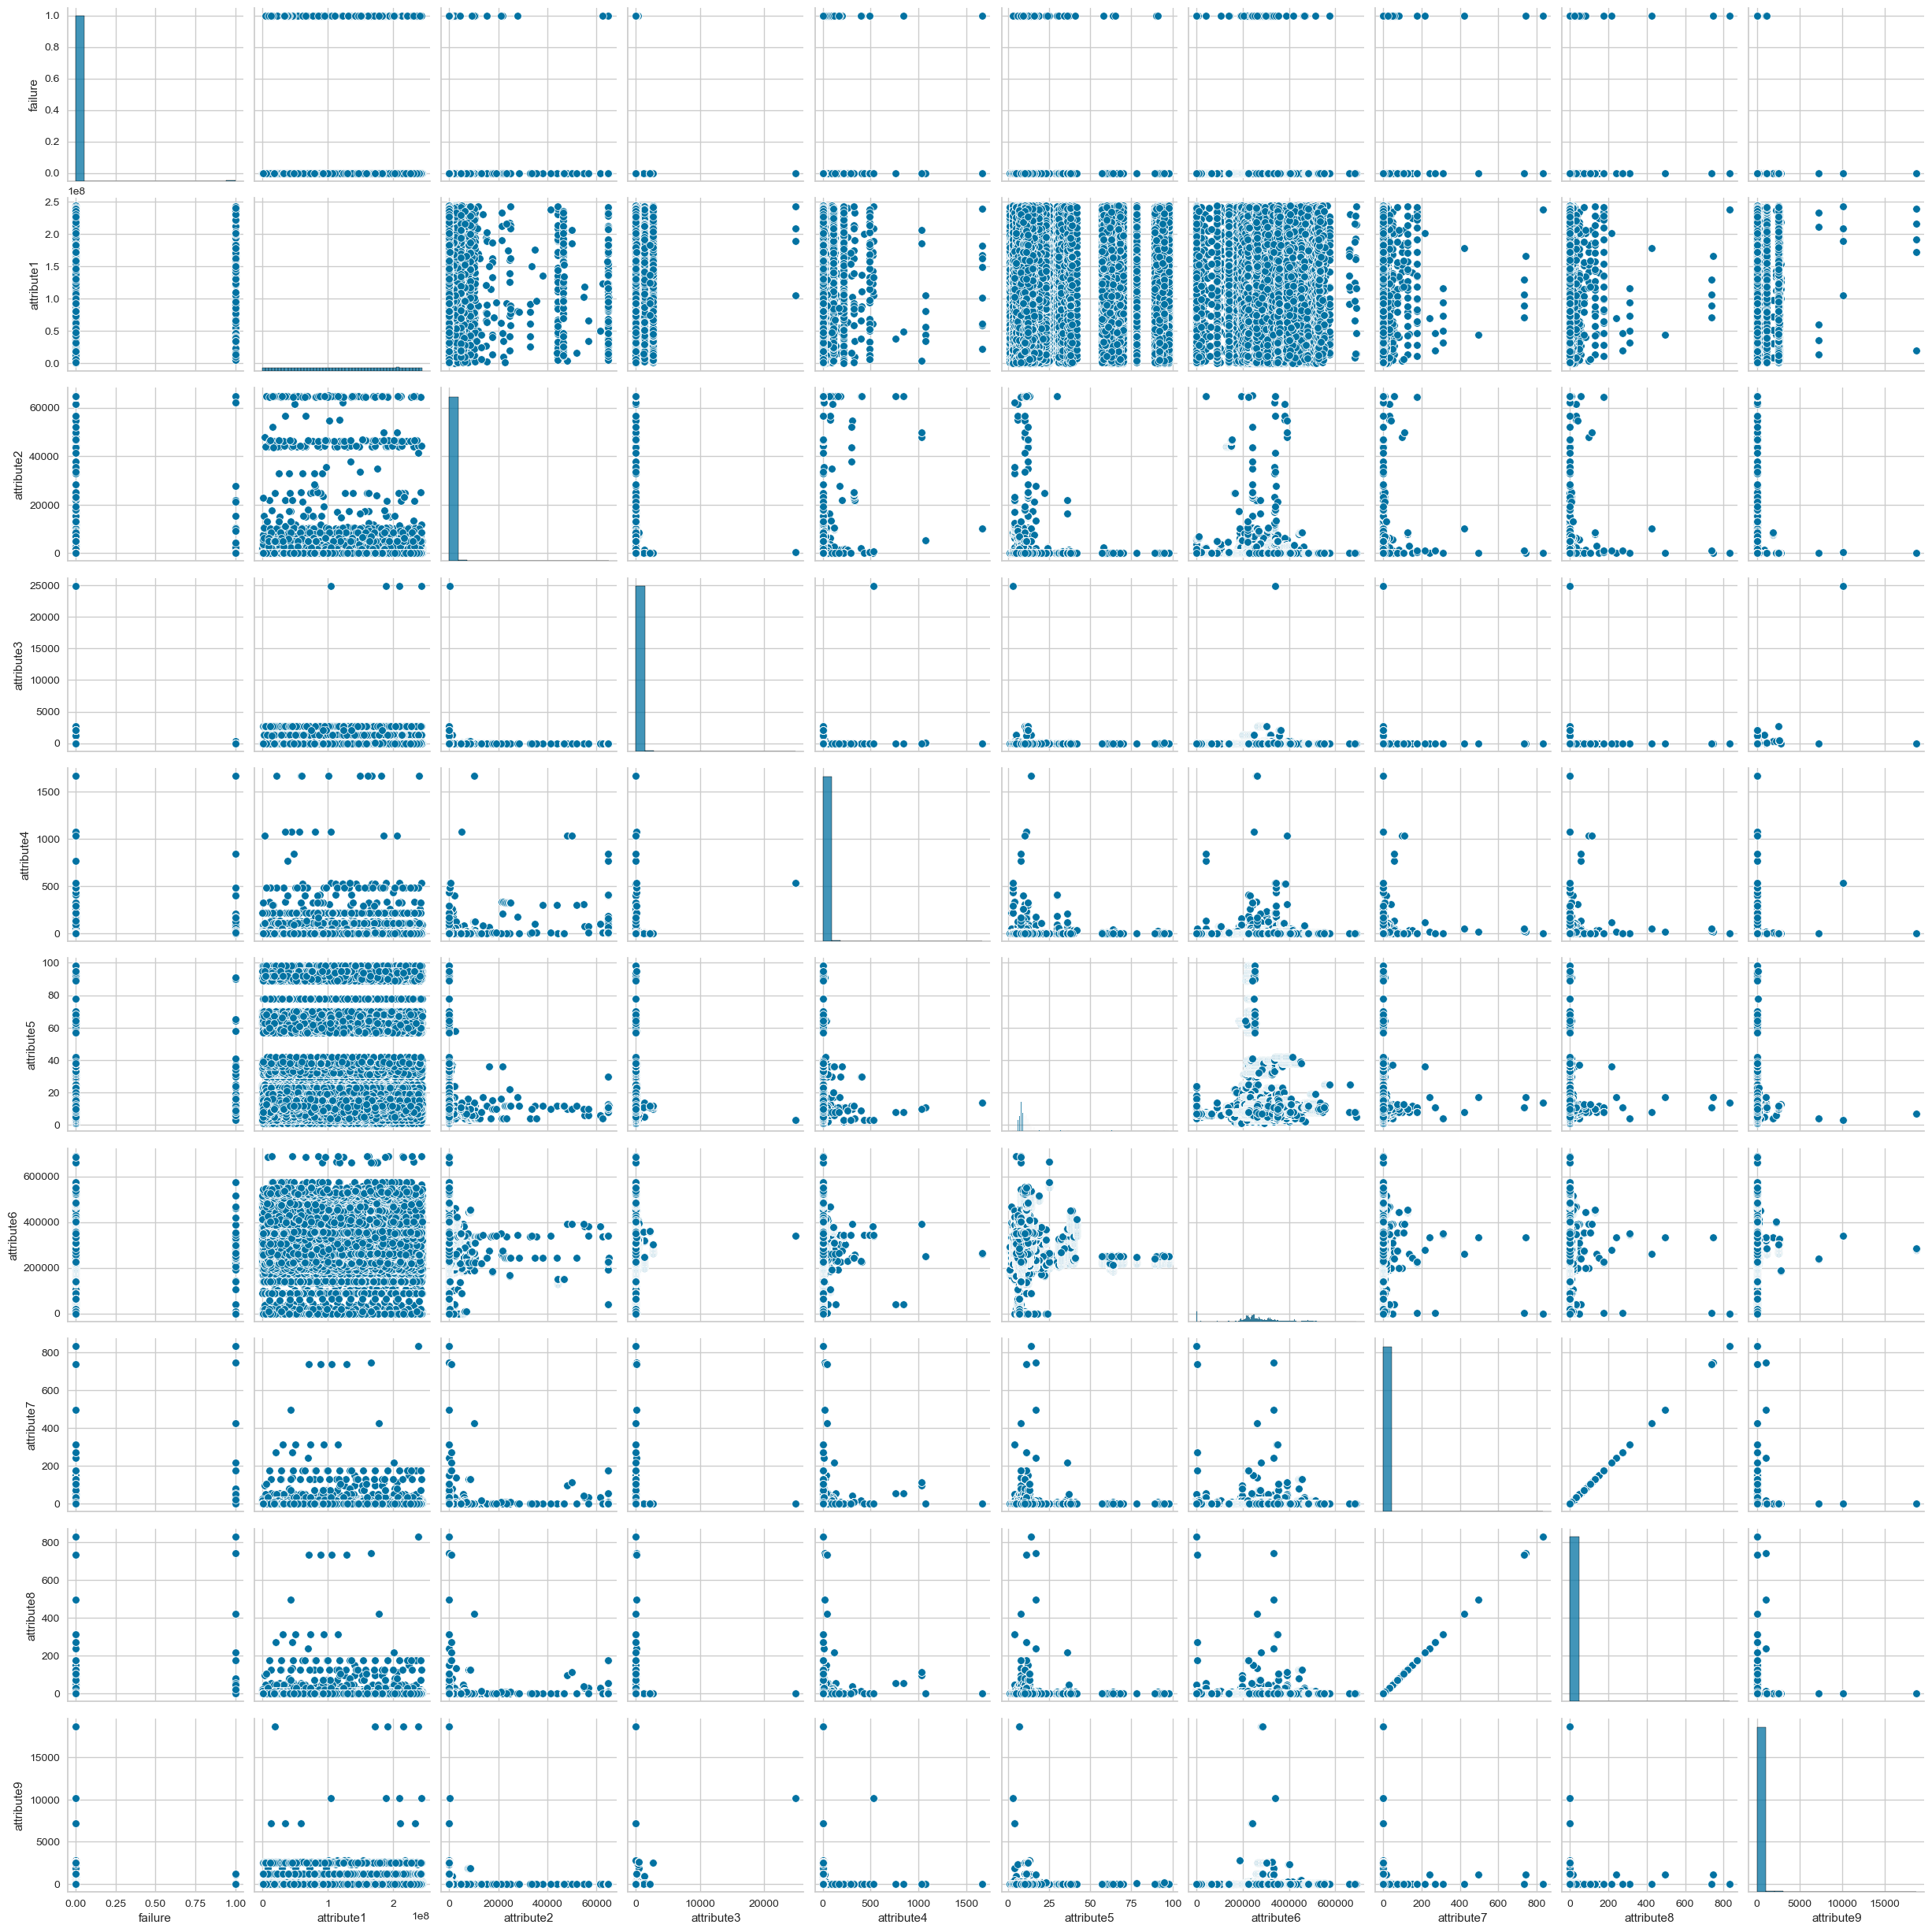

In [20]:
sns.pairplot(df);

<Axes: xlabel='failure', ylabel='count'>

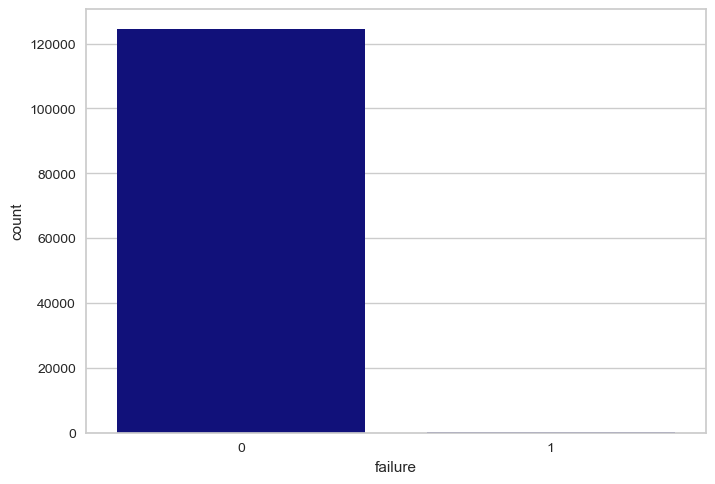

In [21]:
sns.countplot(x=df["failure"],color="darkblue")

In [23]:
df["failure"].value_counts()
# 1---failure,  0----non-failure

failure
0    124388
1       106
Name: count, dtype: int64

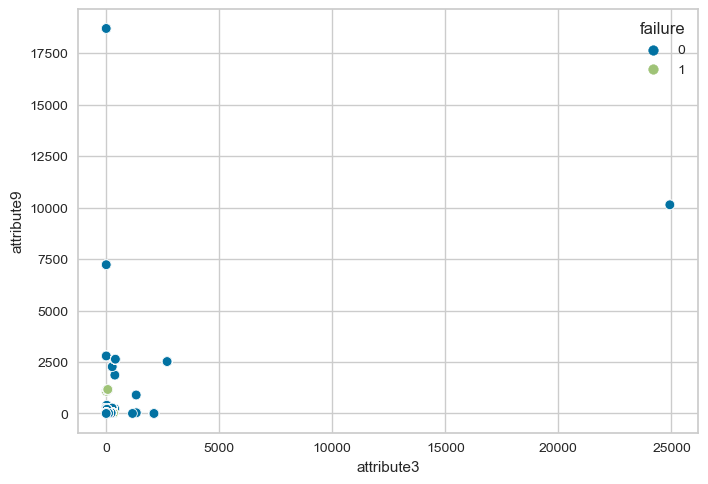

In [25]:
# attribute3 - attribute9 --- 0.53 correlated
sns.scatterplot(df, x="attribute3", y="attribute9", hue="failure");

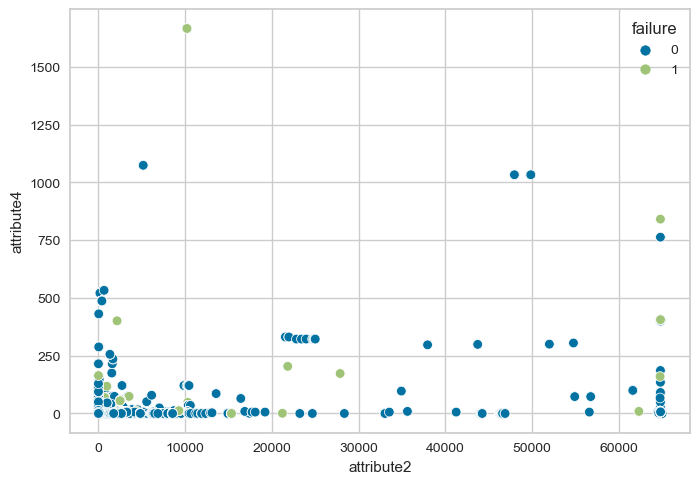

In [26]:
# attribute2 - attribute4 --- 0.15 correlated
sns.scatterplot(df, x="attribute2", y="attribute4", hue="failure");

## Feature engineering

In [29]:
df["attribute7"].describe()

count   124494.000
mean         0.293
std          7.437
min          0.000
25%          0.000
50%          0.000
75%          0.000
max        832.000
Name: attribute7, dtype: float64

In [30]:
df["attribute8"].describe()

count   124494.000
mean         0.293
std          7.437
min          0.000
25%          0.000
50%          0.000
75%          0.000
max        832.000
Name: attribute8, dtype: float64

In [5]:
# attribute8 and attribute7 same so delete attribute8
del(df["attribute8"])

In [6]:
df["date"] = pd.to_datetime(df["date"])

In [7]:
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df = df.drop("date",axis=1)

In [8]:
abs(df.corr(numeric_only=True)["failure"]).sort_values(ascending=False)

failure      1.000
attribute7   0.119
attribute4   0.067
attribute2   0.053
day          0.003
attribute5   0.002
attribute1   0.002
attribute9   0.002
attribute3   0.001
attribute6   0.001
month        0.000
year           NaN
Name: failure, dtype: float64

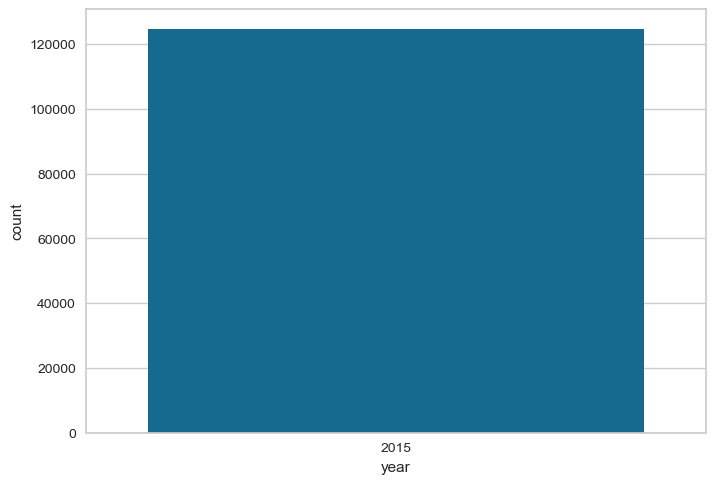

In [9]:
sns.countplot(x=df["year"]);

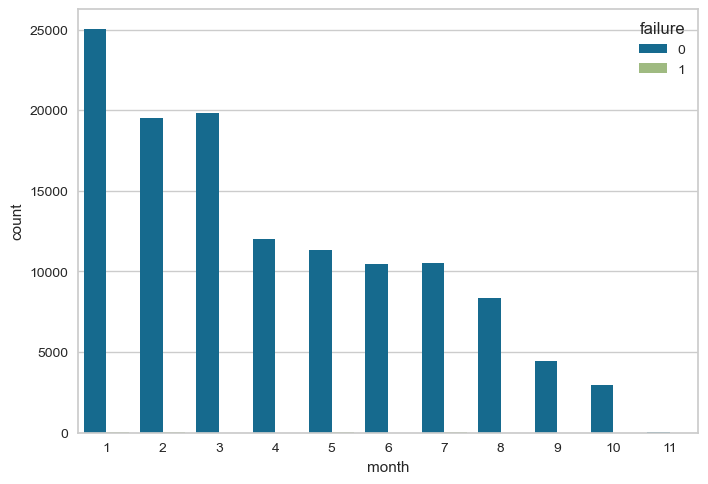

In [10]:
sns.countplot(x=df["month"], hue=df["failure"]);

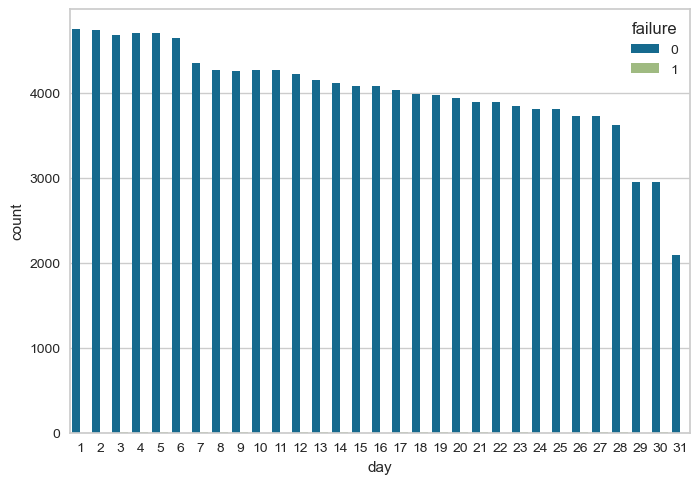

In [11]:
sns.countplot(x=df["day"],hue=df["failure"]);

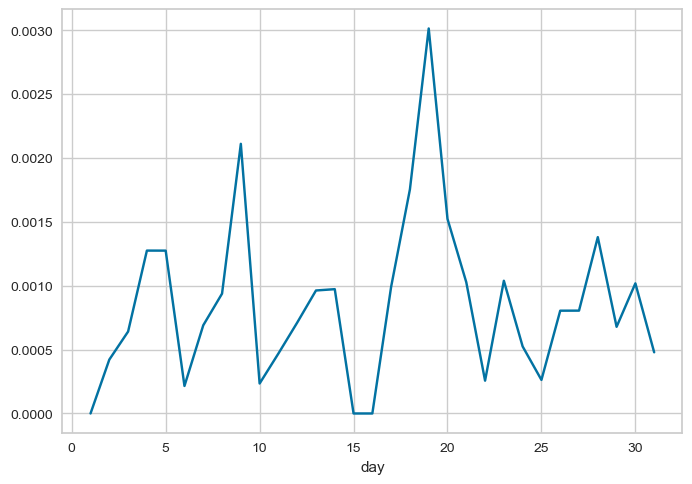

In [12]:
df.groupby("day")["failure"].mean().plot();

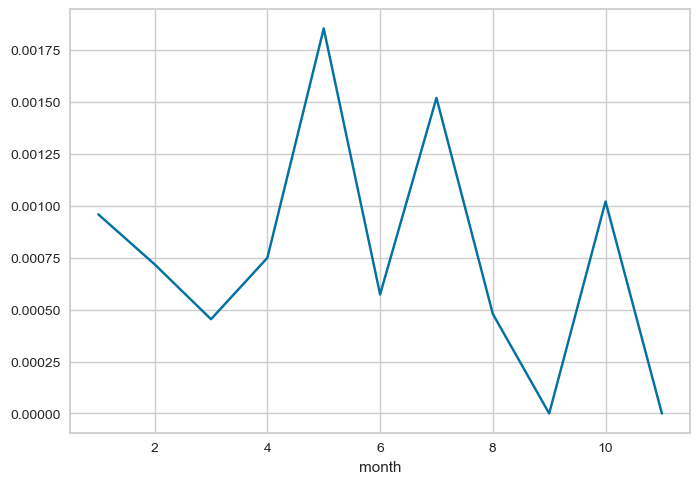

In [13]:
df.groupby("month")["failure"].mean().plot();

In [14]:
df["device"].value_counts()

device
S1F0FGBQ    304
W1F0SJJ2    304
Z1F0GE1M    304
Z1F0KJDS    304
Z1F0KKN4    304
           ... 
Z1F0LT6P      5
Z1F0LT6Z      5
W1F1CJKT      5
S1F04KSC      4
W1F0WJFT      3
Name: count, Length: 1168, dtype: int64

In [15]:
df["device"].nunique()

1168

In [16]:
df["device"] = df["device"].str[:3]
df["device"].value_counts()

device
S1F    54858
W1F    43268
Z1F    26368
Name: count, dtype: int64

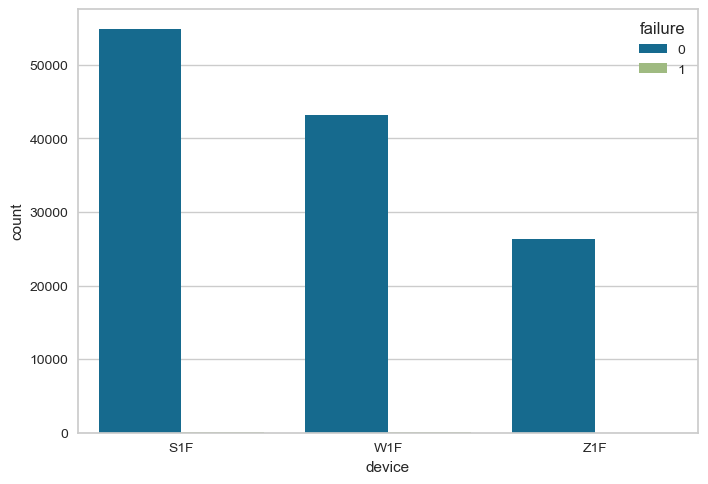

In [17]:
sns.countplot(x=df["device"], hue=df["failure"]);

<Axes: xlabel='device'>

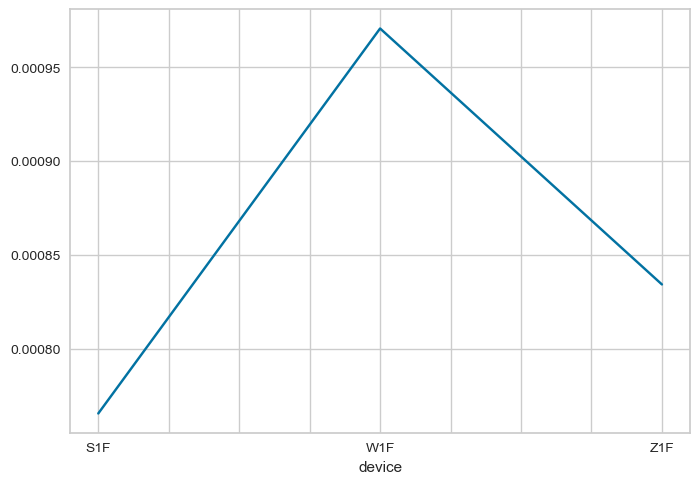

In [18]:
df.groupby("device")["failure"].mean().plot()

In [19]:
df.to_pickle("featured_df.pkl")


In [43]:
df = pd.read_pickle("featured_df.pkl")

## Outlier Analysis

In [44]:
def analyze_outliers(df, columns):
    outlier_summary = []
    for column in columns:
        Q1 = df[column].quantile(0.10)
        Q3 = df[column].quantile(0.90)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        num_outliers = outliers.shape[0]
        
        outlier_summary.append({
            'column': column,
            'num_outliers': num_outliers,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })
        
        print(f"{column}: {num_outliers} outliers")
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}\n")
    
    return pd.DataFrame(outlier_summary)

# Example usage
# Assuming 'df' is your DataFrame and it contains columns named 'age' and 'salary'
outlier_analysis = analyze_outliers(df, ['attribute1', 'attribute2','attribute3','attribute4','attribute5','attribute6','attribute7','attribute9'])

print(outlier_analysis)

attribute1: 0 outliers
Lower bound: -268494399.6, Upper bound: 512250986.0

attribute2: 6384 outliers
Lower bound: 0.0, Upper bound: 0.0

attribute3: 9135 outliers
Lower bound: 0.0, Upper bound: 0.0

attribute4: 9338 outliers
Lower bound: 0.0, Upper bound: 0.0

attribute5: 7312 outliers
Lower bound: -16.5, Upper bound: 43.5

attribute6: 31 outliers
Lower bound: -73805.10000000003, Upper bound: 637328.5

attribute7: 1458 outliers
Lower bound: 0.0, Upper bound: 0.0

attribute9: 7949 outliers
Lower bound: -4.5, Upper bound: 7.5

       column  num_outliers    lower_bound   upper_bound
0  attribute1             0 -268494399.600 512250986.000
1  attribute2          6384          0.000         0.000
2  attribute3          9135          0.000         0.000
3  attribute4          9338          0.000         0.000
4  attribute5          7312        -16.500        43.500
5  attribute6            31     -73805.100    637328.500
6  attribute7          1458          0.000         0.000
7  attribute

In [34]:
df.shape

(124494, 13)

In [45]:
def drop_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.10)
        Q3 = df[column].quantile(0.90)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Only keep rows in dataframe that do not contain any outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
    return df


df = drop_outliers(df, ['attribute1', 'attribute2','attribute3','attribute4','attribute5','attribute6','attribute7','attribute9'])


print(f"New DataFrame shape without outliers: {df.shape}")


New DataFrame shape without outliers: (91690, 13)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91690 entries, 2 to 124493
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   device      91690 non-null  object
 1   failure     91690 non-null  int64 
 2   attribute1  91690 non-null  int64 
 3   attribute2  91690 non-null  int64 
 4   attribute3  91690 non-null  int64 
 5   attribute4  91690 non-null  int64 
 6   attribute5  91690 non-null  int64 
 7   attribute6  91690 non-null  int64 
 8   attribute7  91690 non-null  int64 
 9   attribute9  91690 non-null  int64 
 10  day         91690 non-null  int32 
 11  month       91690 non-null  int32 
 12  year        91690 non-null  int32 
dtypes: int32(3), int64(9), object(1)
memory usage: 8.7+ MB


## Data preprocessing

In [46]:
X = df.drop("failure", axis=1)
y = df[["failure"]]

In [47]:
X = pd.get_dummies(X, drop_first=True)

In [48]:
scaler= StandardScaler()
X = scaler.fit_transform(X)

In [49]:
oversample = SMOTE()
X, y = oversample.fit_resample(X,y)

In [41]:
def fit_and_predict_classification_models(X, y):
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Dictionary of classification models
    models = {
        "Logistic Regression": LogisticRegression(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Support Vector Machine": SVC(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
        "Ada Boost": AdaBoostClassifier()
        }
    
    # Fitting models and printing accuracy
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")


fit_and_predict_classification_models(X, y)


Logistic Regression Accuracy: 0.7193
K-Nearest Neighbors Accuracy: 0.9980
Support Vector Machine Accuracy: 0.9871
Decision Tree Accuracy: 0.9995
Random Forest Accuracy: 0.9999
Gradient Boosting Accuracy: 0.9910
GaussianNB Accuracy: 0.7510
BernoulliNB Accuracy: 0.7118
Ada Boost Accuracy: 0.9564


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
rf = RandomForestClassifier()
model_rf = rf.fit(X_train,y_train)
rf_pred = model_rf.predict(X_test)
accuracy_score(rf_pred,y_test)

0.9998363740489241

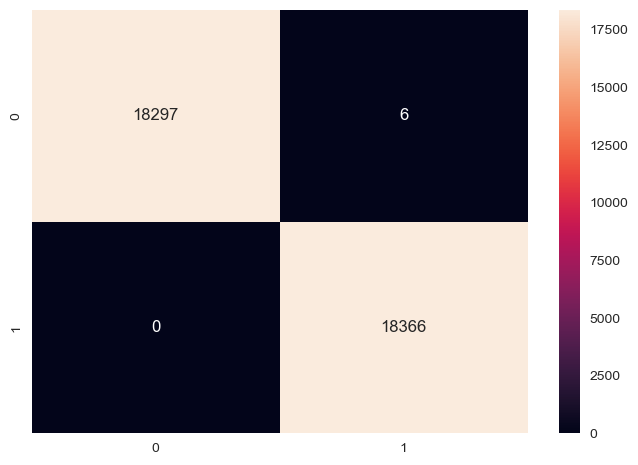

In [62]:
sns.heatmap(confusion_matrix(rf_pred,y_test), annot=True, fmt=".0f");

In [56]:
print(classification_report(rf_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18303
           1       1.00      1.00      1.00     18366

    accuracy                           1.00     36669
   macro avg       1.00      1.00      1.00     36669
weighted avg       1.00      1.00      1.00     36669



In [58]:
abc = AdaBoostClassifier()
model_ada = abc.fit(X_train,y_train)
pred_ada = model_ada.predict(X_test)
accuracy_score(pred_ada,y_test)

0.9502849818647904

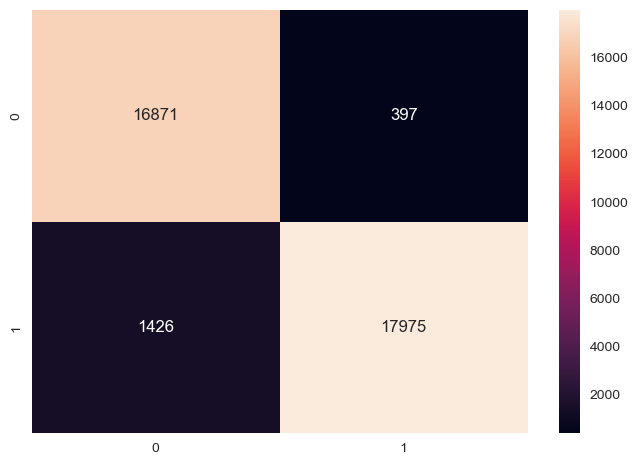

In [61]:
sns.heatmap(confusion_matrix(pred_ada,y_test), annot=True, fmt=".0f");

In [63]:
print(classification_report(pred_ada,y_test))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     17268
           1       0.98      0.93      0.95     19401

    accuracy                           0.95     36669
   macro avg       0.95      0.95      0.95     36669
weighted avg       0.95      0.95      0.95     36669

